Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from itertools import cycle
from numpy import interp
from sklearn.model_selection import cross_val_score
from hyperopt import hp, fmin, tpe, space_eval
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
from sklearn.ensemble import RandomForestClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
%matplotlib inline
%run ./classifier_evaluation.ipynb

import dataset

In [2]:
pd.set_option('display.max_columns', None)  # Show all columns
raw_data = pd.read_csv('GENEPY_JULY2021_all.csv')

raw_data.info()

data_1 = raw_data.copy() # Create data copy

data_1 = data_1.infer_objects()  # Automatically correct the data type of each column

data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1087 entries, 0 to 1086
Columns: 16384 entries, confirmed_diag to ZNF32
dtypes: float64(16378), int64(5), object(1)
memory usage: 135.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1087 entries, 0 to 1086
Columns: 16384 entries, confirmed_diag to ZNF32
dtypes: float64(16378), int64(5), object(1)
memory usage: 135.9+ MB


In [3]:
raw_data_2 = pd.read_csv('fuentes_falsePos.csv')

raw_data_2.info()

data_2 = raw_data_2.copy() # Create data copy

data_2 = data_2.infer_objects()  # Automatically correct the data type of each column

data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2156 entries, 0 to 2155
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   a1/3GTP  2156 non-null   object
dtypes: object(1)
memory usage: 17.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2156 entries, 0 to 2155
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   a1/3GTP  2156 non-null   object
dtypes: object(1)
memory usage: 17.0+ KB


In [4]:
data_1['confirmed_diag'].value_counts()

CD                681
UC                368
IBDU               25
NOT IBD             5
UC/CD               4
Patchy colitis      1
Other               1
UNKNOWN             1
IBDU                1
Name: confirmed_diag, dtype: int64

In [5]:
frequency_table = data_1['confirmed_diag'].value_counts(ascending=True)
print('Frequency Table for Confirmed Diseases:') 
print(frequency_table)

Frequency Table for Confirmed Diseases:
IBDU                1
UNKNOWN             1
Other               1
Patchy colitis      1
UC/CD               4
NOT IBD             5
IBDU               25
UC                368
CD                681
Name: confirmed_diag, dtype: int64


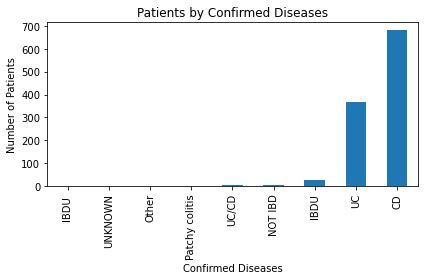

In [6]:
frequency_table.plot(kind='bar')
plt.xlabel('Confirmed Diseases')
plt.ylabel('Number of Patients')
plt.title('Patients by Confirmed Diseases')
plt.tight_layout()
plt.savefig('fig1.eps', dpi=400, format='eps', bbox_inches = 'tight');

In [7]:
data_1 = data_1.drop(data_1[data_1['confirmed_diag'] == 'IBDU'].index)
data_1 = data_1.drop(data_1[data_1['confirmed_diag'] == 'NOT IBD'].index)
data_1 = data_1.drop(data_1[data_1['confirmed_diag'] == 'UC/CD'].index)
data_1 = data_1.drop(data_1[data_1['confirmed_diag'] == 'UNKNOWN'].index)
data_1 = data_1.drop(data_1[data_1['confirmed_diag'] == 'Patchy colitis'].index)
data_1 = data_1.drop(data_1[data_1['confirmed_diag'] == 'Other'].index)
data_1 = data_1.drop(data_1[data_1['confirmed_diag'] == 'IBDU '].index)

In [8]:
data_1['confirmed_diag'].value_counts()

data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1049 entries, 0 to 1085
Columns: 16384 entries, confirmed_diag to ZNF32
dtypes: float64(16378), int64(5), object(1)
memory usage: 131.1+ MB


In [27]:
data_1_CD_NOD2 = data_1.loc[data_1["confirmed_diag"] == "CD", "NOD2"]
data_1_UC_NOD2 = data_1.loc[data_1["confirmed_diag"] == "UC", "NOD2"]

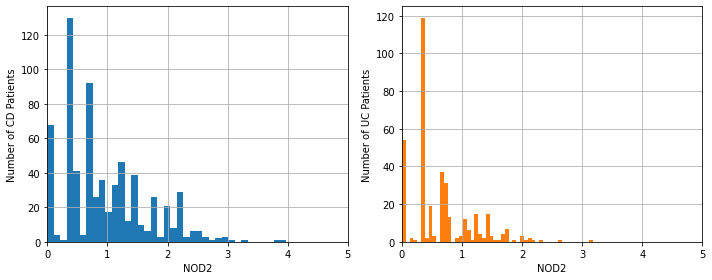

In [28]:
fig = plt.figure(figsize=(10,4))
#fig.set_title("The distribution of NOD2 gene in the CD/UC class")
ax0 = fig.add_subplot(1, 2, 1)
ax0.set_xlim(0,5)
#ax0.set_ylim(0.0,2.0)
ax0.set_xlabel("NOD2", fontsize=10)
ax0.set_ylabel("Number of CD Patients", fontsize=10)
data_1_CD_NOD2.hist(bins=50)
ax1 = fig.add_subplot(1, 2, 2)
ax1.hist(data_1_UC_NOD2, bins=50)
ax1.set_xlim(0,5)
#ax1.set_ylim(0.0,2.0)
ax1.set_xlabel("NOD2", fontsize=10)
ax1.set_ylabel("Number of UC Patients", fontsize=10)
data_1_UC_NOD2.hist(bins=50)
fig.tight_layout()
fig.savefig('fig2.eps', dpi=400, format='eps', bbox_inches = 'tight');
#ax[1].set_ylim(0.0,2.0)

Remove the false-positive signal features from the lists

In [29]:
fuentes_falsePos_list = list(data_2['a1/3GTP'])[0:]
features_list = list(data_1.columns)[1:]
c = 0
for feature in features_list:
    for fuentes_falsePos in fuentes_falsePos_list:
        if(feature == fuentes_falsePos):
            c+=1
            #print(c)
            #print(feature)
            #print(fuentes_falsePos)
            data_1 = data_1.drop([feature], axis=1)
            break

In [30]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1049 entries, 0 to 1085
Columns: 15995 entries, confirmed_diag to ZNF32
dtypes: float64(15989), int64(5), object(1)
memory usage: 128.0+ MB


take top ten genes from Imogen's talk

In [31]:
X1 = data_1.loc[:, ['NOD2','TEK','PLCL1','SP110','SNAPC4','ITPR3','CYP1B1','FCRL5','CX3CR1','TNFSF11']].values
data_1.loc[data_1["confirmed_diag"] == "CD", "confirmed_diag"] = 1
data_1.loc[data_1["confirmed_diag"] == "UC", "confirmed_diag"] = 0
y1 = data_1['confirmed_diag']
y1 = y1.astype('int').values

In [32]:
#X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.30, random_state = 42)
# scale all predictor values to the range [0, 1] separately for the training and the test folds
# note the target attribute 'type' is already binary 
#X1_train = min_max_scaler.fit_transform(X1_train)
#X1_test = min_max_scaler.fit_transform(X1_test)
#oversampler = RandomOverSampler(random_state=0)
#X1_train, y1_train = oversampler.fit_resample(X1_train, y1_train)

Randomized Search

In [53]:
# 定义超参搜索空间
distributions = {'kernel':['linear', 'rbf'], 'C':uniform(loc=1, scale=9), 'gamma':['scale', 'auto'], 'probability':[True]}
# 初始化模型
svc = svm.SVC()
# 网格搜索 
clf_1 = RandomizedSearchCV(estimator = svc,
                         param_distributions = distributions,
                         n_iter = 10,
                         scoring = 'accuracy',
                         cv = 10,
                         n_jobs = -1,
                         random_state = 2021)
clf_1.fit(X1, y1)

RandomizedSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000024F02327AF0>,
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'rbf'],
                                        'probability': [True]},
                   random_state=2021, scoring='accuracy')

In [54]:
print('详细结果:\n', pd.DataFrame.from_dict(clf_1.cv_results_))
print('最佳分类器:\n', clf_1.best_estimator_)
print('最佳分数:\n', clf_1.best_score_)
print('最佳参数:\n', clf_1.best_params_)

详细结果:
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_C  \
0       0.223108      0.033295         0.001995        0.000446   6.4538   
1       0.134048      0.012981         0.001795        0.000399  2.25052   
2       0.210243      0.007239         0.002892        0.000299  9.97519   
3       0.146708      0.018973         0.002394        0.001197  2.61094   
4       0.245544      0.035350         0.001795        0.000748  6.95944   
5       0.197272      0.014925         0.003291        0.000457  1.87205   
6       0.235645      0.020860         0.003241        0.001026  9.66156   
7       0.183833      0.009885         0.003295        0.000455  1.77967   
8       0.202470      0.045515         0.001336        0.000459  6.54872   
9       0.181838      0.024497         0.002695        0.000638  6.16874   

  param_gamma param_kernel param_probability  \
0        auto       linear              True   
1       scale       linear              True   
2        aut

In [55]:
#linear_SVM_classifier_1 = LinearSVC(random_state=0, tol=1e-5, class_weight='balanced', max_iter=10000)
SVM_classifier_1 = svm.SVC(C=1.8720495633237473, gamma='auto', probability=True, kernel='rbf', random_state=0, tol=1e-5, class_weight='balanced', max_iter=10000)
mean_fpr = np.linspace(start=0, stop=1, num=100)
# used below to scale all predictor values to the range [0, 1]
# this is done separately for each fold in cross validation
min_max_scaler = preprocessing.MinMaxScaler()

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_SVM_1, f1_scores_SVM_1, tprs_SVM_1, aucs_SVM_1 = evaluate_classifier(folds=10, 
                                                                        p=X1, t=y1, 
                                                                        classifier=SVM_classifier_1, 
                                                                        mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

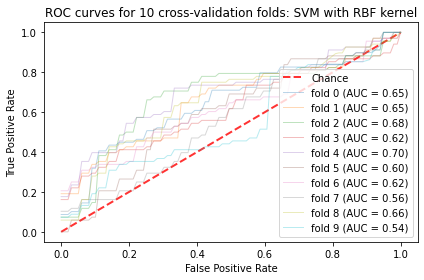

In [56]:
# Plot an ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_SVM_1, aucs_SVM_1, 'SVM with RBF kernel')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

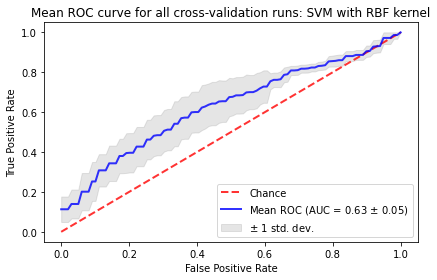

In [57]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_SVM_1, aucs_SVM_1, 'SVM with RBF kernel')

Bayesian Optimization

In [42]:
# step1: 定义目标函数
def objective(params):
    # 初始化模型并交叉验证
    svc = svm.SVC(**params)
    cv_scores = cross_val_score(svc, X1, y1, cv=10)
    # 返回loss = 1 - accuracy (loss必须被最小化)
    loss = 1 - cv_scores.mean()
    return loss

In [43]:
# step2: 定义超参搜索空间
space = {'kernel':hp.choice('kernel', ['linear', 'rbf']),
         'C':hp.uniform('C', 1, 10), 
          'probability':hp.choice('probability',[True]),
          'gamma': hp.choice('gamma', ['scale', 'auto'])}

In [44]:
#step3: 在给定超参搜索空间下，最小化目标函数
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)

100%|██████████| 100/100 [01:27<00:00,  1.14trial/s, best loss: 0.3422161172161172]


In [45]:
# step4: 打印结果
print(best)

{'C': 2.2346735816226655, 'gamma': 1, 'kernel': 1, 'probability': 0}


In [46]:
#linear_SVM_classifier_1 = LinearSVC(random_state=0, tol=1e-5, class_weight='balanced', max_iter=10000)
SVM_classifier_11 = svm.SVC(C = 2.2346735816226655, kernel='rbf', probability=True, gamma='auto', random_state=0, tol=1e-5, class_weight='balanced', max_iter=10000)
mean_fpr = np.linspace(start=0, stop=1, num=100)
# used below to scale all predictor values to the range [0, 1]
# this is done separately for each fold in cross validation
min_max_scaler = preprocessing.MinMaxScaler()

In [47]:
# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_SVM_11, f1_scores_SVM_11, tprs_SVM_11, aucs_SVM_11 = evaluate_classifier(folds=10, 
                                                                        p=X1, t=y1, 
                                                                        classifier=SVM_classifier_11, 
                                                                        mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

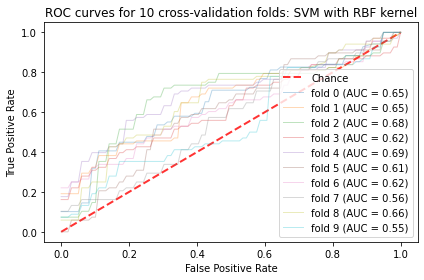

In [48]:
# Plot an ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_SVM_11, aucs_SVM_11, 'SVM with RBF kernel')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

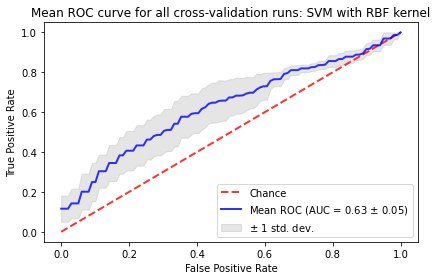

In [49]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_SVM_11, aucs_SVM_11, 'SVM with RBF kernel')

Grid Search

In [58]:
# 定义超参搜索空间
parameters = {'kernel':['linear', 'rbf'], 'C':[1, 10], 'gamma':['scale', 'auto'], 'probability':[True]}
# 初始化模型
svc = svm.SVC()
# 网格搜索
clf_2 = GridSearchCV(estimator = svc,
                   param_grid = parameters,
                   scoring = 'accuracy',
                   n_jobs = -1,
                   cv = 10)
clf_2.fit(X1, y1)

GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf'], 'probability': [True]},
             scoring='accuracy')

In [59]:
print('详细结果:\n', pd.DataFrame.from_dict(clf_2.cv_results_))
print('最佳分类器:\n', clf_2.best_estimator_)
print('最佳分数:\n', clf_2.best_score_)
print('最佳参数:\n', clf_2.best_params_)

详细结果:
    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0       0.106313      0.006970         0.001695        0.000457       1   
1       0.177930      0.008492         0.003491        0.000919       1   
2       0.103528      0.007889         0.001895        0.000299       1   
3       0.178823      0.003091         0.002891        0.000299       1   
4       0.305710      0.045020         0.001797        0.000596      10   
5       0.230883      0.008477         0.003491        0.000668      10   
6       0.294707      0.029578         0.001796        0.000397      10   
7       0.189924      0.022509         0.001946        0.000789      10   

  param_gamma param_kernel param_probability  \
0       scale       linear              True   
1       scale          rbf              True   
2        auto       linear              True   
3        auto          rbf              True   
4       scale       linear              True   
5       scale          rbf   

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

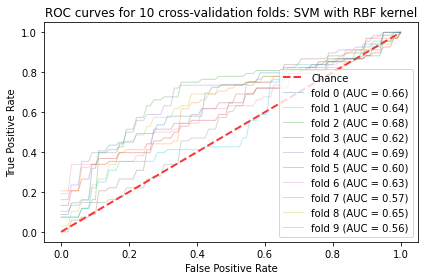

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

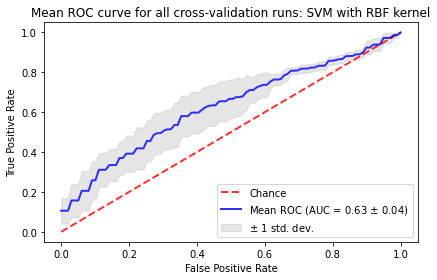

In [61]:
#linear_SVM_classifier_1 = LinearSVC(random_state=0, tol=1e-5, class_weight='balanced', max_iter=10000)
SVM_classifier_111 = svm.SVC(C = 1, kernel='rbf', probability=True, gamma='auto', random_state=0, tol=1e-5, class_weight='balanced', max_iter=10000)
mean_fpr = np.linspace(start=0, stop=1, num=100)
# used below to scale all predictor values to the range [0, 1]
# this is done separately for each fold in cross validation
min_max_scaler = preprocessing.MinMaxScaler()

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_SVM_111, f1_scores_SVM_111, tprs_SVM_111, aucs_SVM_111 = evaluate_classifier(folds=10, 
                                                                        p=X1, t=y1, 
                                                                        classifier=SVM_classifier_111, 
                                                                        mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold
# Plot an ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_SVM_111, aucs_SVM_111, 'SVM with RBF kernel')

# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_SVM_111, aucs_SVM_111, 'SVM with RBF kernel')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

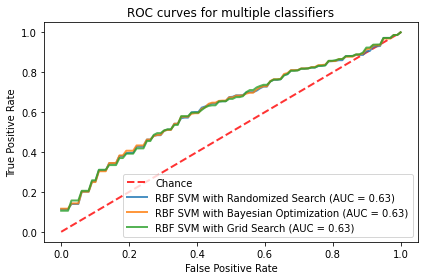

In [62]:
plot_roc_multiple_classifiers(mean_fpr, 
                              np.stack((np.mean(tprs_SVM_1, axis=0), np.mean(tprs_SVM_11, axis=0), np.mean(tprs_SVM_111, axis=0))), 
                              np.array([np.mean(aucs_SVM_1), np.mean(aucs_SVM_11), np.mean(aucs_SVM_111)]), 
                              np.array(['RBF SVM with Randomized Search', 'RBF SVM with Bayesian Optimization', 'RBF SVM with Grid Search']))

Random Forests

Randomized Search

In [64]:
random_search = {'criterion': ['entropy', 'gini'],
               'max_depth': list(np.linspace(10, 1200, 10, dtype = int)) + [None],
               'max_features': ['auto', 'sqrt','log2', None],
               'min_samples_leaf': [4, 6, 8, 12],
               'min_samples_split': [5, 7, 10, 14],
               'n_estimators': list(np.linspace(151, 1200, 10, dtype = int))}

clf_1 = RandomForestClassifier(n_jobs=-1, random_state=0)
model_1 = RandomizedSearchCV(estimator = clf_1, param_distributions = random_search, n_iter = 80, 
                               cv = 10, verbose= 5, random_state= 101, n_jobs = -1)
model_1.fit(X1,y1)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  2.9min finished


RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
                   n_iter=80, n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [10, 142, 274, 406, 538,
                                                      671, 803, 935, 1067, 1200,
                                                      None],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [4, 6, 8, 12],
                                        'min_samples_split': [5, 7, 10, 14],
                                        'n_estimators': [151, 267, 384, 500,
                                                         617, 733, 850, 966,
                                                         1083, 1200]},
                   random_state=101, 

In [65]:
print('详细结果:\n', pd.DataFrame.from_dict(model_1.cv_results_))
print('最佳分类器:\n', model_1.best_estimator_)
print('最佳分数:\n', model_1.best_score_)
print('最佳参数:\n', model_1.best_params_)

详细结果:
     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.661231      0.025423         0.062733        0.008229   
1        3.187403      0.202047         0.190737        0.018061   
2        0.761472      0.173970         0.070412        0.020347   
3        3.333783      0.285619         0.279535        0.072264   
4        3.092138      0.341775         0.153867        0.018842   
..            ...           ...              ...             ...   
75       0.732266      0.189164         0.085576        0.017595   
76       4.463567      0.512864         0.244616        0.078372   
77       4.968932      0.515149         0.226993        0.026322   
78       5.567070      0.417866         0.285709        0.100317   
79       4.307735      0.717987         0.138743        0.026161   

   param_n_estimators param_min_samples_split param_min_samples_leaf  \
0                 267                      14                      4   
1                 966           

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

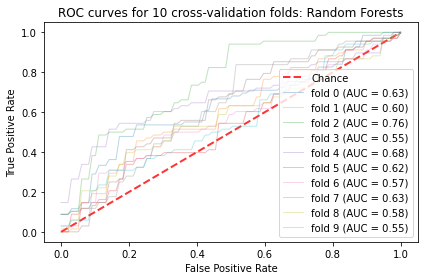

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

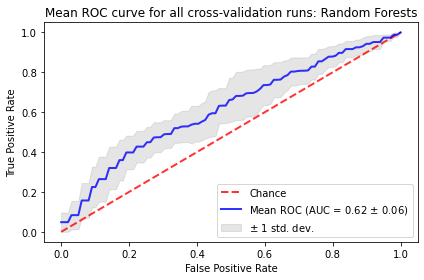

In [67]:
mean_fpr = np.linspace(start=0, stop=1, num=100)
# used below to scale all predictor values to the range [0, 1]
# this is done separately for each fold in cross validation
min_max_scaler = preprocessing.MinMaxScaler()

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_RF_1, f1_scores_RF_1, tprs_RF_1, aucs_RF_1 = evaluate_classifier(folds=10, 
                                                                        p=X1, t=y1, 
                                                                        classifier=model_1.best_estimator_, 
                                                                        mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

# Plot an ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_RF_1, aucs_RF_1, 'Random Forests')

# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_RF_1, aucs_RF_1, 'Random Forests')

Grid Seach

In [69]:
grid_search = {
    'criterion': [model_1.best_params_['criterion']],
    'max_depth': [model_1.best_params_['max_depth']],
    'max_features': [model_1.best_params_['max_features']],
    'min_samples_leaf': [model_1.best_params_['min_samples_leaf'] - 2, 
                         model_1.best_params_['min_samples_leaf'], 
                         model_1.best_params_['min_samples_leaf'] + 2],
    'min_samples_split': [model_1.best_params_['min_samples_split'] - 3, 
                          model_1.best_params_['min_samples_split'], 
                          model_1.best_params_['min_samples_split'] + 3],
    'n_estimators': [model_1.best_params_['n_estimators'] - 150, 
                     model_1.best_params_['n_estimators'] - 100, 
                     model_1.best_params_['n_estimators'], 
                     model_1.best_params_['n_estimators'] + 100, 
                     model_1.best_params_['n_estimators'] + 150]
}

clf_11 = RandomForestClassifier(n_jobs=-1, random_state=0)
model_11 = GridSearchCV(estimator = clf_11, param_grid = grid_search, 
                               cv = 4, verbose= 5, n_jobs = -1)
model_11.fit(X1,y1)
print('详细结果:\n', pd.DataFrame.from_dict(model_11.cv_results_))
print('最佳分类器:\n', model_11.best_estimator_)
print('最佳分数:\n', model_11.best_score_)
print('最佳参数:\n', model_11.best_params_)

Fitting 4 folds for each of 45 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    8.4s finished


详细结果:
     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.023687      0.000827         0.002493        0.000500   
1        0.142483      0.008658         0.020425        0.001572   
2        0.370357      0.005832         0.044438        0.002939   
3        0.687275      0.034652         0.087190        0.018764   
4        0.828767      0.018085         0.073659        0.007649   
5        0.010066      0.000010         0.001010        0.001010   
6        0.131987      0.016114         0.025681        0.002159   
7        0.519859      0.027960         0.046140        0.006292   
8        0.911696      0.009169         0.066323        0.003630   
9        0.843144      0.058657         0.074052        0.003756   
10       0.013963      0.001222         0.001496        0.000498   
11       0.121748      0.001381         0.025293        0.002904   
12       0.421774      0.010367         0.049119        0.007476   
13       0.886878      0.017930         0

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

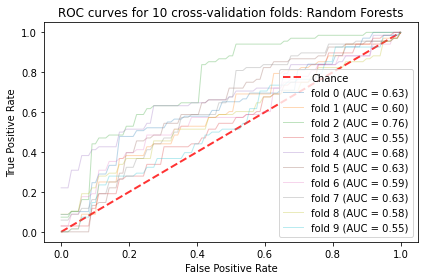

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

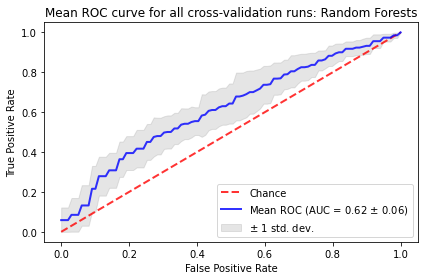

In [70]:
mean_fpr = np.linspace(start=0, stop=1, num=100)
# used below to scale all predictor values to the range [0, 1]
# this is done separately for each fold in cross validation
min_max_scaler = preprocessing.MinMaxScaler()

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_RF_11, f1_scores_RF_11, tprs_RF_11, aucs_RF_11 = evaluate_classifier(folds=10, 
                                                                        p=X1, t=y1, 
                                                                        classifier=model_11.best_estimator_, 
                                                                        mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

# Plot an ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_RF_11, aucs_RF_11, 'Random Forests')

# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_RF_11, aucs_RF_11, 'Random Forests')

In [72]:
space = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
        'max_depth': hp.quniform('max_depth', 10, 1200, 10),
        'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
        'min_samples_leaf': hp.uniform ('min_samples_leaf', 0, 0.5),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : hp.choice('n_estimators', [10, 50, 300, 750, 1200])
    }

def objective(space):
    model_111 = RandomForestClassifier(criterion = space['criterion'], 
                                   max_depth = space['max_depth'],
                                 max_features = space['max_features'],
                                 min_samples_leaf = space['min_samples_leaf'],
                                 min_samples_split = space['min_samples_split'],
                                 n_estimators = space['n_estimators'], 
                                 )
    
    accuracy = cross_val_score(model_111, X1, y1, cv = 10).mean()

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }
    
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 80,
            trials= trials)
best

100%|██████████| 80/80 [07:03<00:00,  5.29s/trial, best loss: -0.656831501831502] 


{'criterion': 0,
 'max_depth': 750.0,
 'max_features': 2,
 'min_samples_leaf': 0.02742554056123979,
 'min_samples_split': 0.19224757752957233,
 'n_estimators': 2}

In [73]:
crit = {0: 'entropy', 1: 'gini'}
feat = {0: 'auto', 1: 'sqrt', 2: 'log2', 3: None}
est = {0: 10, 1: 50, 2: 300, 3: 750, 4: 1200}

trainedforest = RandomForestClassifier(criterion = crit[best['criterion']], 
                                       max_depth = best['max_depth'], 
                                       max_features = feat[best['max_features']], 
                                       min_samples_leaf = best['min_samples_leaf'], 
                                       min_samples_split = best['min_samples_split'], 
                                       n_estimators = est[best['n_estimators']]
                                      ).fit(X1,y1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

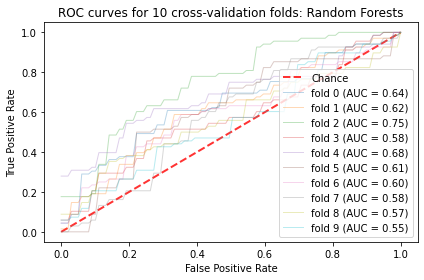

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

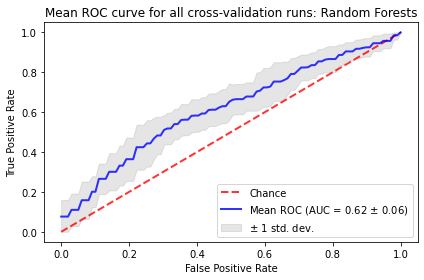

In [76]:
mean_fpr = np.linspace(start=0, stop=1, num=100)
# used below to scale all predictor values to the range [0, 1]
# this is done separately for each fold in cross validation
min_max_scaler = preprocessing.MinMaxScaler()

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_RF_111, f1_scores_RF_111, tprs_RF_111, aucs_RF_111 = evaluate_classifier(folds=10, 
                                                                        p=X1, t=y1, 
                                                                        classifier=trainedforest, 
                                                                        mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

# Plot an ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_RF_111, aucs_RF_111, 'Random Forests')

# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_RF_111, aucs_RF_111, 'Random Forests')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

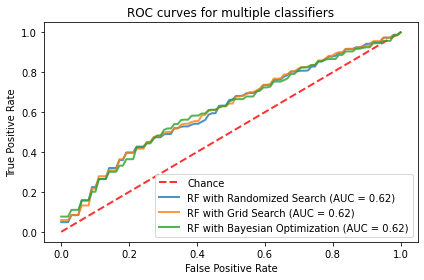

In [77]:
plot_roc_multiple_classifiers(mean_fpr, 
                              np.stack((np.mean(tprs_RF_1, axis=0), np.mean(tprs_RF_11, axis=0), np.mean(tprs_RF_111, axis=0))), 
                              np.array([np.mean(aucs_RF_1), np.mean(aucs_RF_11), np.mean(aucs_RF_111)]), 
                              np.array(['RF with Randomized Search', 'RF with Grid Search', 'RF with Bayesian Optimization']))

SVM vs RF

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


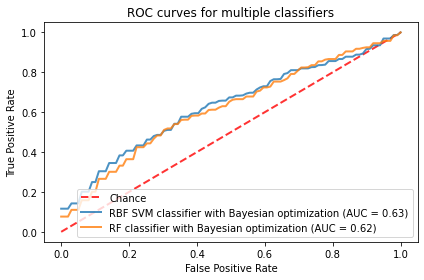

In [78]:
plot_roc_multiple_classifiers(mean_fpr, 
                              np.stack((np.mean(tprs_SVM_11, axis=0), np.mean(tprs_RF_111, axis=0))), 
                              np.array([np.mean(aucs_SVM_11), np.mean(aucs_RF_111)]), 
                              np.array(['RBF SVM classifier with Bayesian optimization', 'RF classifier with Bayesian optimization']))